# Cours 4 : Machine Learning - Algorithmes supervisés (2/2)

## Préambule

Les objectifs de cette séance (3h) sont :
* Préparation des bases de modélisation (sampling)
* Construire un modèle de Machine Learning (cross-validation et hyperparamétrage) pour résoudre un problème de classification
* Analyser les performances du modèle

## Préparation du workspace

### Import de librairies 

In [ ]:
# Données
import numpy as np
import pandas as pd

# Graphiques
import seaborn as sns

sns.set()
from imblearn.over_sampling import RandomOverSampler

import plotly.express as px

# Statistiques
from scipy.stats import chi2_contingency

# Machine Learning
import sklearn.preprocessing as preproc
from sklearn import metrics
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import (
    GridSearchCV,
    StratifiedKFold,
    cross_val_score,
    train_test_split,
)

### Définition des fonctions 

In [103]:
def cramers_V(var1, var2):
    crosstab = np.array(
        pd.crosstab(var1, var2, rownames=None, colnames=None),
    )  # Cross table building
    stat = chi2_contingency(crosstab)[
        0
    ]  # Keeping of the test statistic of the Chi2 test
    obs = np.sum(crosstab)  # Number of observations
    mini = (
        min(crosstab.shape) - 1
    )  # Take the minimum value between the colmns and the rows of the cross table
    return stat / (obs * mini)

### Constantes

In [104]:
input_path = "./1_inputs"
output_path = "./2_outputs"

### Import des données

In [105]:
path = input_path + "/base_retraitee.csv"
data_retraitee = pd.read_csv(path, sep=",", decimal=".")

## Préparation de la base de données

Dans cette partie nous souhaitons expliquer la survenance d'un sinistre en fonction des variables explicatives i.e. une variable binaire qui : 
* est égale à 1 si la personne a eu 1 ou plus de sinistres.
* est égale à 0 le cas échéant.

In [106]:
data_model = data_retraitee

# Calcul de la variable "sinistré" qui est vrai si la personne a eu un ou plusieurs sinistres ou faux le cas échéant
data_model["SINISTRE"] = data_model["NB"] > 0
data_model = data_model.drop(["CHARGE", "NB", "EXPO"], axis=1)
data_model.head()

ANNEE_CTR CONTRAT_ANCIENNETE FREQUENCE_PAIEMENT_COTISATION      GROUPE_KM  \
0       2019             (-1,0]                        ANNUEL  [20000;40000[   
1       2019             (-1,0]                        ANNUEL  [20000;40000[   
2       2021              (1,2]                        ANNUEL      [0;20000[   
3       2021              (2,5]                        ANNUEL      [0;20000[   
4       2018              (2,5]                       MENSUEL  [20000;40000[   

  ZONE_RISQUE  AGE_ASSURE_PRINCIPAL GENRE  DEUXIEME_CONDUCTEUR  \
0           B                    54     M                False   
1           B                    88     F                 True   
2           D                    35     F                 True   
3           C                    46     M                False   
4           A                    46     F                False   

   ANCIENNETE_PERMIS  ANNEE_CONSTRUCTION  ENERGIE EQUIPEMENT_SECURITE  \
0                 47              2016.0  ESSENCE                FAUX   
1                 55              2018.0   DIESEL                VRAI   
2                 16              2017.0  ESSENCE                FAUX   
3                 44              2018.0  ESSENCE                VRAI   
4                 31              2009.0   DIESEL                FAUX   

  VALEUR_DU_BIEN  SINISTRE  
0  [10000;15000[     False  
1  [20000;25000[     False  
2  [15000;20000[     False  
3  [35000;99999[     False  
4  [10000;15000[     False

**Exercice :** construisez les statistiques descriptives de la base utilisée. Notamment la distribution de la variable réponse.

In [107]:
data_model.describe(include="all")

ANNEE_CTR CONTRAT_ANCIENNETE FREQUENCE_PAIEMENT_COTISATION  \
count   14236.000000              14236                         14236   
unique           NaN                  5                             3   
top              NaN              (0,1]                       MENSUEL   
freq             NaN               4174                          6854   
mean     2018.769247                NaN                           NaN   
std         1.655911                NaN                           NaN   
min      2016.000000                NaN                           NaN   
25%      2017.000000                NaN                           NaN   
50%      2019.000000                NaN                           NaN   
75%      2020.000000                NaN                           NaN   
max      2021.000000                NaN                           NaN   

        GROUPE_KM ZONE_RISQUE  AGE_ASSURE_PRINCIPAL  GENRE  \
count       14236       14236          14236.000000  14236   
unique          4          17                   NaN      2   
top     [0;20000[           C                   NaN      M   
freq         7653        4867                   NaN   8387   
mean          NaN         NaN             45.023391    NaN   
std           NaN         NaN             13.636799    NaN   
min           NaN         NaN             18.000000    NaN   
25%           NaN         NaN             35.000000    NaN   
50%           NaN         NaN             44.000000    NaN   
75%           NaN         NaN             54.000000    NaN   
max           NaN         NaN             94.000000    NaN   

       DEUXIEME_CONDUCTEUR  ANCIENNETE_PERMIS  ANNEE_CONSTRUCTION  ENERGIE  \
count                14236       14236.000000        14236.000000    14236   
unique                   2                NaN                 NaN        3   
top                  False                NaN                 NaN  ESSENCE   
freq                 11222                NaN                 NaN     7294   
mean                   NaN          36.362391         2015.389646      NaN   
std                    NaN          18.875462            3.507688      NaN   
min                    NaN           1.000000         1961.000000      NaN   
25%                    NaN          19.000000         2014.000000      NaN   
50%                    NaN          35.000000         2016.000000      NaN   
75%                    NaN          53.000000         2017.000000      NaN   
max                    NaN          70.000000         2021.000000      NaN   

       EQUIPEMENT_SECURITE VALEUR_DU_BIEN SINISTRE  
count                14236          14236    14236  
unique                   2              6        2  
top                   FAUX  [10000;15000[    False  
freq                  9396           3629    13412  
mean                   NaN            NaN      NaN  
std                    NaN            NaN      NaN  
min                    NaN            NaN      NaN  
25%                    NaN            NaN      NaN  
50%                    NaN            NaN      NaN  
75%                    NaN            NaN      NaN  
max                    NaN            NaN      NaN

In [108]:
# Observation de la distribution
fig = px.histogram(
    data_model,
    x="SINISTRE",
    title="Distribution de la variable 'sinistré'",
)
fig.show()

#### Etude des corrélations parmi les variables explicatives

In [109]:
data_set = data_model.drop("SINISTRE", axis=1)
data_set.shape

(14236, 13)

In [110]:
# Séparation en variables qualitatives ou catégorielles
variables_na = []
variables_numeriques = []
variables_01 = []
variables_categorielles = []
for col in data_set.columns:
    if True in data_model[col].isna().unique():
        variables_na.append(data_model[col])
    elif str(data_model[col].dtypes) in ["int32", "int64", "float64"]:
        if len(data_model[col].unique()) == 2:
            variables_categorielles.append(data_model[col])
        else:
            variables_numeriques.append(data_model[col])
    elif len(data_model[col].unique()) == 2:
        variables_categorielles.append(data_model[col])
    else:
        variables_categorielles.append(data_model[col])

##### Corrélation des variables catégorielles :

In [111]:
vars_categorielles = pd.DataFrame(variables_categorielles).transpose()

In [112]:
# Test du V de Cramer
rows = []

for var1 in vars_categorielles:
    col = []
    for var2 in vars_categorielles:
        cramers = cramers_V(
            vars_categorielles[var1],
            vars_categorielles[var2],
        )  # V de Cramer
        col.append(round(cramers, 2))  # arrondi du résultat
    rows.append(col)

cramers_results = np.array(rows)
v_cramer_resultats = pd.DataFrame(
    cramers_results,
    columns=vars_categorielles.columns,
    index=vars_categorielles.columns,
)

v_cramer_resultats

CONTRAT_ANCIENNETE  \
CONTRAT_ANCIENNETE                           1.00   
FREQUENCE_PAIEMENT_COTISATION                0.00   
GROUPE_KM                                    0.01   
ZONE_RISQUE                                  0.02   
GENRE                                        0.00   
DEUXIEME_CONDUCTEUR                          0.00   
ENERGIE                                      0.00   
EQUIPEMENT_SECURITE                          0.01   
VALEUR_DU_BIEN                               0.00   

                               FREQUENCE_PAIEMENT_COTISATION  GROUPE_KM  \
CONTRAT_ANCIENNETE                                      0.00       0.01   
FREQUENCE_PAIEMENT_COTISATION                           1.00       0.00   
GROUPE_KM                                               0.00       1.00   
ZONE_RISQUE                                             0.00       0.01   
GENRE                                                   0.01       0.01   
DEUXIEME_CONDUCTEUR                                     0.00       0.00   
ENERGIE                                                 0.00       0.04   
EQUIPEMENT_SECURITE                                     0.01       0.01   
VALEUR_DU_BIEN                                          0.02       0.02   

                               ZONE_RISQUE  GENRE  DEUXIEME_CONDUCTEUR  \
CONTRAT_ANCIENNETE                    0.02   0.00                  0.0   
FREQUENCE_PAIEMENT_COTISATION         0.00   0.01                  0.0   
GROUPE_KM                             0.01   0.01                  0.0   
ZONE_RISQUE                           1.00   0.00                  0.0   
GENRE                                 0.00   1.00                  0.0   
DEUXIEME_CONDUCTEUR                   0.00   0.00                  1.0   
ENERGIE                               0.01   0.02                  0.0   
EQUIPEMENT_SECURITE                   0.03   0.01                  0.0   
VALEUR_DU_BIEN                        0.00   0.07                  0.0   

                               ENERGIE  EQUIPEMENT_SECURITE  VALEUR_DU_BIEN  
CONTRAT_ANCIENNETE                0.00                 0.01            0.00  
FREQUENCE_PAIEMENT_COTISATION     0.00                 0.01            0.02  
GROUPE_KM                         0.04                 0.01            0.02  
ZONE_RISQUE                       0.01                 0.03            0.00  
GENRE                             0.02                 0.01            0.07  
DEUXIEME_CONDUCTEUR               0.00                 0.00            0.00  
ENERGIE                           1.00                 0.02            0.08  
EQUIPEMENT_SECURITE               0.02                 1.00            0.07  
VALEUR_DU_BIEN                    0.08                 0.07            1.00

In [113]:
# On repère les variables trop corrélées
for i in range(v_cramer_resultats.shape[0]):
    for j in range(i + 1, v_cramer_resultats.shape[0]):
        if v_cramer_resultats.iloc[i, j] > 0.7:
            print(
                f"{v_cramer_resultats.index.to_numpy()[i]} et {v_cramer_resultats.colmns[j]} sont trop dépendantes, V-CRAMER = {v_cramer_resultats.iloc[i, j]}",
            )

##### Corrélation des variables numériques :

In [114]:
vars_numeriques = pd.DataFrame(variables_numeriques).transpose()

**Question :** quels sont vos commentaires ?

In [115]:
# Corrélation de Pearson
correlations_num = vars_numeriques.corr(method="pearson")
correlations_num

ANNEE_CTR  AGE_ASSURE_PRINCIPAL  ANCIENNETE_PERMIS  \
ANNEE_CTR              1.000000              0.048023           0.043983   
AGE_ASSURE_PRINCIPAL   0.048023              1.000000           0.498743   
ANCIENNETE_PERMIS      0.043983              0.498743           1.000000   
ANNEE_CONSTRUCTION     0.361550             -0.059184          -0.029814   

                      ANNEE_CONSTRUCTION  
ANNEE_CTR                       0.361550  
AGE_ASSURE_PRINCIPAL           -0.059184  
ANCIENNETE_PERMIS              -0.029814  
ANNEE_CONSTRUCTION              1.000000

In [116]:
# On repère les variables trop corrélées
nb_variables = correlations_num.shape[0]
for i in range(nb_variables):
    for j in range(i + 1, nb_variables):
        if abs(correlations_num.iloc[i, j]) > 0.7:
            print(
                f"{correlations_num.index.to_numpy()[i]} et {correlations_num.columns[j]} sont trop dépendantes, corr = {correlations_num.iloc[i, j]}",
            )

#### Preprocessing

Deux étapes sont nécessaires avant de lancer l'apprentissage d'un modèle, c'est ce qu'on connait comme le *Preprocessing* :

* Les modèles proposés par la librairie "sklearn" ne gèrent que des variables numériques. Il est donc nécessaire de transformer les variables catégorielles en variables numériques : ce processus s'appelle le *One Hot Encoding*.
* Normaliser les données numériques

**Exercice :** proposez un bout de code permettant de réaliser le One Hot Encoding des variables catégorielles. Vous pourrez utiliser la fonction "preproc.OneHotEncoder" de la librairie sklearn

In [117]:
# One hot encoding des variables catégorielles
preproc_ohe = preproc.OneHotEncoder(handle_unknown="ignore")
preproc_ohe = preproc.OneHotEncoder(drop="first", sparse_output=False).fit(
    vars_categorielles,
)

variables_categorielles_ohe = preproc_ohe.transform(vars_categorielles)
variables_categorielles_ohe = pd.DataFrame(
    variables_categorielles_ohe,
    columns=preproc_ohe.get_feature_names_out(vars_categorielles.columns),
)
variables_categorielles_ohe.head()

CONTRAT_ANCIENNETE_(0,1]  CONTRAT_ANCIENNETE_(1,2]  \
0                       0.0                       0.0   
1                       0.0                       0.0   
2                       0.0                       1.0   
3                       0.0                       0.0   
4                       0.0                       0.0   

   CONTRAT_ANCIENNETE_(2,5]  CONTRAT_ANCIENNETE_(5,10]  \
0                       0.0                        0.0   
1                       0.0                        0.0   
2                       0.0                        0.0   
3                       1.0                        0.0   
4                       1.0                        0.0   

   FREQUENCE_PAIEMENT_COTISATION_MENSUEL  \
0                                    0.0   
1                                    0.0   
2                                    0.0   
3                                    0.0   
4                                    1.0   

   FREQUENCE_PAIEMENT_COTISATION_TRIMESTRIEL  GROUPE_KM_[20000;40000[  \
0                                        0.0                      1.0   
1                                        0.0                      1.0   
2                                        0.0                      0.0   
3                                        0.0                      0.0   
4                                        0.0                      1.0   

   GROUPE_KM_[40000;60000[  GROUPE_KM_[60000;99999[  ZONE_RISQUE_B  ...  \
0                      0.0                      0.0            1.0  ...   
1                      0.0                      0.0            1.0  ...   
2                      0.0                      0.0            0.0  ...   
3                      0.0                      0.0            0.0  ...   
4                      0.0                      0.0            0.0  ...   

   GENRE_M  DEUXIEME_CONDUCTEUR_True  ENERGIE_DIESEL  ENERGIE_ESSENCE  \
0      1.0                       0.0             0.0              1.0   
1      0.0                       1.0             1.0              0.0   
2      0.0                       1.0             0.0              1.0   
3      1.0                       0.0             0.0              1.0   
4      0.0                       0.0             1.0              0.0   

   EQUIPEMENT_SECURITE_VRAI  VALEUR_DU_BIEN_[10000;15000[  \
0                       0.0                           1.0   
1                       1.0                           0.0   
2                       0.0                           0.0   
3                       1.0                           0.0   
4                       0.0                           1.0   

   VALEUR_DU_BIEN_[15000;20000[  VALEUR_DU_BIEN_[20000;25000[  \
0                           0.0                           0.0   
1                           0.0                           1.0   
2                           1.0                           0.0   
3                           0.0                           0.0   
4                           0.0                           0.0   

   VALEUR_DU_BIEN_[25000;35000[  VALEUR_DU_BIEN_[35000;99999[  
0                           0.0                           0.0  
1                           0.0                           0.0  
2                           0.0                           0.0  
3                           0.0                           1.0  
4                           0.0                           0.0  

[5 rows x 35 columns]

**Exercice :** proposez un bout de code permettant noramliser les variables numériques présentes dans la base. Vous pourrez utiliser la fonction "preproc.StandardScaler" de la librairie sklearn

In [ ]:
# Normalisation des varibales numériques
preproc_scale = preproc.StandardScaler(with_mean=True, with_std=True)
preproc_scale.fit(vars_numeriques)

vars_numeriques_scaled = preproc_scale.transform(vars_numeriques)
vars_numeriques_scaled = pd.DataFrame(
    vars_numeriques_scaled,
    columns=vars_numeriques.columns,
)
vars_numeriques_scaled.head()

ANNEE_CTR  AGE_ASSURE_PRINCIPAL  ANCIENNETE_PERMIS  ANNEE_CONSTRUCTION
0   0.139356              0.658287           0.563588            0.174011
1   0.139356              3.151628           0.987434            0.744207
2   1.347192             -0.735051          -1.078814            0.459109
3   1.347192              0.071618           0.404646            0.744207
4  -0.464562              0.071618          -0.284103           -1.821676

## Algorithme supervisé : Gradient Boosting

A ce stade, nous avons vu les différentes étapes pour lancer un algorithme de Machine Learning. Néanmoins, ces étapes ne sont pas suffisantes pour construire un modèle performant.  
En effet, afin de construire un modèle performant le Data Scientist doit agir sur l'apprentissage du modèle. Dans ce qui suit nous :
* Changerons d'algorithme pour utiliser un algorithme plus performant (Gradient Boosting)
* Raliserons un *grid search* sur les paramètres du modèle
* Appliquerons l'apprentissage par validation croisée


**Exercice :** Implémentez l'algorithme du Gradient Boosting en appliquant les techniques vues lors des derniers cours (sampling, Grid search et Cross Validation)  
**Remarques :**
* Vous pouvez utiliser les modèles "GradientBoostingClassifier" et "GridSearchCV" de la libraire Sklearn.  
* Pensez à utiliser les métriques relatives aux problèmes de classification.

#### Sampling

In [ ]:
X_global = vars_numeriques_scaled.merge(
    variables_categorielles_ohe,
    left_index=True,
    right_index=True,
)
# Réorganisation des données
X = X_global.to_numpy()
Y = np.array(data_model["SINISTRE"])

In [120]:
# Sampling en 80% train et 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X,
    Y,
    test_size=0.2,
    random_state=42,
    stratify=Y,
)

#### Fitting avec Cross-Validation et *Grid Search*

In [ ]:
# Définir la grille d'hyperparamètres à rechercher
param_grid = {
    "n_estimators": [100, 200, 250],
    "learning_rate": [0.5, 0.7, 0.9],
}

# Nombre de folds pour la validation croisée
num_folds = 5

In [122]:
# Initialisation du modèle GradientBoostingClassifier
gbc = GradientBoostingClassifier(random_state=42)

# Création de l'objet GridSearchCV pour la recherche sur grille avec validation croisée
grid_search = GridSearchCV(
    estimator=gbc,
    param_grid=param_grid,
    cv=StratifiedKFold(
        n_splits=num_folds,
        shuffle=True,
        random_state=42,
    ),  # Validation croisée avec 5 folds
    scoring="recall",  # Métrique d'évaluation (moins c'est mieux)
    n_jobs=-1,  # Utiliser tous les cœurs du processeur
)

# Exécution de la recherche sur grille
grid_search.fit(X_train, y_train)

# Afficher les meilleurs hyperparamètres
best_params = grid_search.best_params_
print("Meilleurs hyperparamètres : ", best_params)

Meilleurs hyperparamètres :  {'learning_rate': 0.9, 'n_estimators': 250}


In [123]:
# Initialiser le modèle final avec les meilleurs hyperparamètres
best_gbc = GradientBoostingClassifier(random_state=42, **best_params)

In [124]:
# Recall de chaque fold
recall_scores = cross_val_score(
    best_gbc,
    X_train,
    y_train,
    cv=num_folds,
    scoring="recall",
)

# Afficher les scores pour chaque fold
for i, score in enumerate(recall_scores):
    print(f"Recall pour le fold {i + 1}: {score}")

# Accuracy de chaque fold
accuracy_scores = cross_val_score(
    best_gbc,
    X_train,
    y_train,
    cv=num_folds,
    scoring="accuracy",
)

# Afficher les scores pour chaque fold
print("\n")
for i, score in enumerate(accuracy_scores):
    print(f"Accuracy pour le fold {i + 1}: {score}")

# Precision de chaque fold
precision_scores = cross_val_score(
    best_gbc,
    X_train,
    y_train,
    cv=num_folds,
    scoring="precision",
)

# Afficher les scores pour chaque fold
print("\n")
for i, score in enumerate(precision_scores):
    print(f"Precision pour le fold {i + 1}: {score}")

Recall pour le fold 1: 0.015151515151515152
Recall pour le fold 2: 0.022727272727272728
Recall pour le fold 3: 0.030303030303030304
Recall pour le fold 4: 0.007633587786259542
Recall pour le fold 5: 0.022727272727272728


Accuracy pour le fold 1: 0.9293239683933274
Accuracy pour le fold 2: 0.9218612818261633
Accuracy pour le fold 3: 0.9341527655838455
Accuracy pour le fold 4: 0.9336846728151076
Accuracy pour le fold 5: 0.9358805445761967


Precision pour le fold 1: 0.06060606060606061
Precision pour le fold 2: 0.057692307692307696
Precision pour le fold 3: 0.15384615384615385
Precision pour le fold 4: 0.045454545454545456
Precision pour le fold 5: 0.15


In [125]:
# Entraîner le modèle final sur la base entière
best_gbc.fit(X_train, y_train)

# Faire des prédictions sur l'ensemble de test
y_pred = best_gbc.predict(X_test)

# Calculer le recall des prédictions
recall = metrics.recall_score(y_test, y_pred)
print(f"Exactitude : {recall}")

Exactitude : 0.024242424242424242


### Fitting avec *Oversampling*

#### *Oversampling*

In [126]:
# Observation de la distribution sur Y_train
df = pd.DataFrame(y_train, columns=["SINISTRE"])
fig = px.histogram(df, x="SINISTRE", title="Distribution de la variable Y_train")
fig.show()

In [127]:
# Oversampling
# Appliquer le suréchantillonnage à la classe minoritaire
sampler = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = sampler.fit_resample(X_train, y_train)

In [128]:
# Observation de la distribution sur Y_train
df = pd.DataFrame(y_train_resampled, columns=["SINISTRE"])
fig = px.histogram(
    df,
    x="SINISTRE",
    title="Distribution de la variable Y_train_resampled",
)
fig.show()

#### Fitting sur le nouvel échantillon

In [129]:
# Définir la grille d'hyperparamètres à rechercher
param_grid = {
    "n_estimators": [475, 500, 525],
    "learning_rate": [0, 7, 0.9, 1.5],
}

# Nombre de folds pour la validation croisée
num_folds = 5

# Initialisation du modèle GradientBoostingClassifier
gb = GradientBoostingClassifier(random_state=42)

In [130]:
# Création de l'objet GridSearchCV pour la recherche sur grille avec validation croisée
grid_search = GridSearchCV(
    estimator=gb,
    param_grid=param_grid,
    cv=StratifiedKFold(
        n_splits=num_folds,
        shuffle=True,
        random_state=42,
    ),  # Validation croisée stratifiée avec 5 plis
    scoring="recall",  # Métrique d'évaluation
    n_jobs=-1,  # Utiliser tous les cœurs du processeur
)

# Exécution de la recherche sur grille
grid_search.fit(X_train_resampled, y_train_resampled)

# Afficher les meilleurs hyperparamètres
best_params = grid_search.best_params_
print("Meilleurs hyperparamètres : ", best_params)

# Initialiser un modèle avec les meilleurs hyperparamètres
best_gbc = GradientBoostingClassifier(random_state=42, **best_params)

Meilleurs hyperparamètres :  {'learning_rate': 0.9, 'n_estimators': 500}


In [131]:
# Zoom sur la CV
# Recall de chaque fold
recall_scores = cross_val_score(
    best_gbc,
    X_train_resampled,
    y_train_resampled,
    cv=num_folds,
    scoring="recall",
)

# Afficher les scores pour chaque fold
for i, score in enumerate(recall_scores):
    print(f"Recall pour le fold {i + 1}: {score}")

# Accuracy de chaque fold
accuracy_scores = cross_val_score(
    best_gbc,
    X_train_resampled,
    y_train_resampled,
    cv=num_folds,
    scoring="accuracy",
)

# Afficher les scores pour chaque fold
print("\n")
for i, score in enumerate(accuracy_scores):
    print(f"Accuracy pour le fold {i + 1}: {score}")

# Precision de chaque fold
precision_scores = cross_val_score(
    best_gbc,
    X_train_resampled,
    y_train_resampled,
    cv=num_folds,
    scoring="precision",
)

# Afficher les scores pour chaque fold
print("\n")
for i, score in enumerate(precision_scores):
    print(f"Precision pour le fold {i + 1}: {score}")

Recall pour le fold 1: 0.9948741845293569
Recall pour le fold 2: 0.9972041006523765
Recall pour le fold 3: 0.9972041006523765
Recall pour le fold 4: 0.9981351981351981
Recall pour le fold 5: 0.9958061509785647


Accuracy pour le fold 1: 0.945479962721342
Accuracy pour le fold 2: 0.9452469711090401
Accuracy pour le fold 3: 0.9391891891891891
Accuracy pour le fold 4: 0.9461663947797716
Accuracy pour le fold 5: 0.9370776042880448


Precision pour le fold 1: 0.9054283290924512
Precision pour le fold 2: 0.9033347403967918
Precision pour le fold 3: 0.8935281837160751
Precision pour le fold 4: 0.9041385135135135
Precision pour le fold 5: 0.8911592994161801


In [132]:
# Entraîner le modèle final sur toute la base
best_gbc.fit(X_train_resampled, y_train_resampled)

GradientBoostingClassifier(learning_rate=0.9, n_estimators=500, random_state=42)

In [133]:
# Faire des prédictions sur l'ensemble de test
y_pred = best_gbc.predict(X_test)

#### Validation du modèle -  métriques

**Exercice :** 
* Construisez la matrice de confusion (metrics.confusion_matrix).
* Calculez les métriques : accuracy, recall & precision.

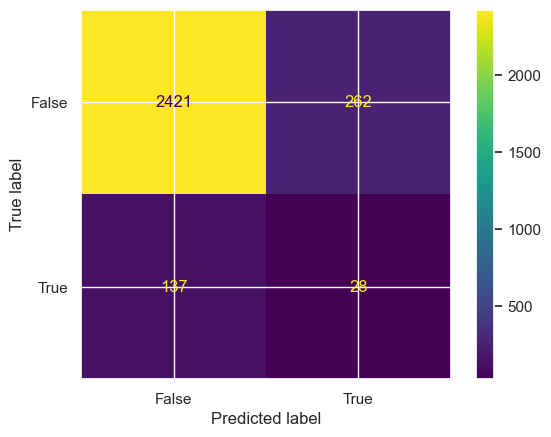

In [134]:
# Matrice de confusion
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix,
    display_labels=[False, True],
)

cm_display.plot()

In [135]:
# Calculer le recall des prédictions
recall = metrics.recall_score(y_test, y_pred)
print(f"Recall : {recall}")

Recall : 0.1696969696969697


In [136]:
# Calculer l'accuracy des prédictions
acc = metrics.accuracy_score(y_test, y_pred)
print(f"Exactitude : {acc}")

Exactitude : 0.8599016853932584


In [137]:
# Calculer le precision des prédictions
precision = metrics.precision_score(y_test, y_pred)
print(f"Precision : {precision}")

Precision : 0.09655172413793103
